<a href="https://colab.research.google.com/github/nickteim/Reinforcement_Learning-/blob/main/VideoTransform_MiDaS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt
from PIL import Image
from skimage import io


# Upload video

In [3]:
# !pip install pytube3

In [4]:
!pip install git+https://github.com/nficano/pytube

  Cloning https://github.com/nficano/pytube to /tmp/pip-req-build-1hgqe_1t
  Running command git clone -q https://github.com/nficano/pytube /tmp/pip-req-build-1hgqe_1t
  Created wheel for pytube: filename=pytube-9.7.0-cp36-none-any.whl size=40388 sha256=6436ed8d636fee6f79fe6e71654df1d7044cfa4c96f24c8b2d54e7b210362b55
  Stored in directory: /tmp/pip-ephem-wheel-cache-plt7kjnv/wheels/44/da/40/3b5e03abe33a91895343814fb44b309512375408f4a909555b
Successfully built pytube


In [6]:
from pytube import YouTube
from moviepy.editor import *
 
# download a file from youtube
youtube_link = 'https://www.youtube.com/watch?v=92U11ya1xuQ'
w = YouTube(youtube_link).streams.first()
w.download(output_path="/content/")

'/content/28 WAYS TO PEEL AND CUT FRUITS LIKE A PRO.mp4'

In [7]:
Location_video='/content/28 WAYS TO PEEL AND CUT FRUITS LIKE A PRO.mp4'

##Proces video

###Split video to images

In [ ]:
## I just did about 6000 images
os.mkdir('/content/test_vid/')
os.mkdir('/content/test_vid/Frames/')
# converting video into frames
vidcap = cv2.VideoCapture(Location_video)
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("/content/test_vid/Frames/%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame:%d, ',count, success)
  count += 1

In [9]:
##zero padding every image name in folder to get the right order
import shutil
import os

sourcedir = "/content/test_vid/Frames"; extensions = (".jpg", ".jpeg")
files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
maxlen = len(max([f[2] for f in files], key = len))

for item in files:
    zeros = maxlen-len(item[2])
    shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

###Get model from github

 github model --> https://pytorch.org/hub/intelisl_midas_v2/

In [10]:
os.mkdir('/content/test_vid/new_model')

In [ ]:
#Running it on a GPU
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

In [12]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.default_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


### Proces images

In [13]:
def setter_inew_model():
  path1_depth = '/content/test_vid/Frames'
  data_depth = os.listdir(path1_depth)
  ordedered_list = sorted(data_depth)
  ordedered_list = ordedered_list


In [14]:
def move_image_new_model(number):  
  for e in ordedered_list[:1]:
    out = "/content/food%d.png" % number
    
    im = Image.open(out)
    im.mode
    'P'
    im = im.convert('RGB')
    im.mode
    'RGB'
    out1 = "/content/test_vid/new_model/%d.jpg" % number
    im.save(out1, quality=95)
    os.remove(out)

In [15]:
path1_depth = '/content/test_vid/Frames'
data_depth = os.listdir(path1_depth)
ordedered_list = sorted(data_depth)
# ordedered_list =


# path1_depth2 = '/content'
# data_depth2 = os.listdir(path1_depth2)
# ordedered_list2 = sorted(data_depth2)
# print(ordedered_list2[5])

def remove(number):
  for i in  ordedered_list[:1]:
    from_folder = '/content/test_vid/Frames/' + i
    print("Removed: ", from_folder)
    os.remove(from_folder)
    
  # for e in ordedered_list2[:1]:
  #   from_folder2 = '/content/' + i
  #   print("Removed: ", from_folder2)
  #   os.remove(from_folder2)

/content/test_vid/Frames/1500.jpg
Removed:  /content/test_vid/Frames/1500.jpg
/content/test_vid/Frames/1501.jpg
Removed:  /content/test_vid/Frames/1501.jpg
/content/test_vid/Frames/1502.jpg
Removed:  /content/test_vid/Frames/1502.jpg
/content/test_vid/Frames/1503.jpg
Removed:  /content/test_vid/Frames/1503.jpg
/content/test_vid/Frames/1504.jpg
Removed:  /content/test_vid/Frames/1504.jpg
/content/test_vid/Frames/1505.jpg
Removed:  /content/test_vid/Frames/1505.jpg
/content/test_vid/Frames/1506.jpg
Removed:  /content/test_vid/Frames/1506.jpg
/content/test_vid/Frames/1507.jpg
Removed:  /content/test_vid/Frames/1507.jpg
/content/test_vid/Frames/1508.jpg
Removed:  /content/test_vid/Frames/1508.jpg
/content/test_vid/Frames/1509.jpg
Removed:  /content/test_vid/Frames/1509.jpg
/content/test_vid/Frames/1510.jpg
Removed:  /content/test_vid/Frames/1510.jpg
/content/test_vid/Frames/1511.jpg
Removed:  /content/test_vid/Frames/1511.jpg
/content/test_vid/Frames/1512.jpg
Removed:  /content/test_vid/Fr

KeyboardInterrupt: ignored

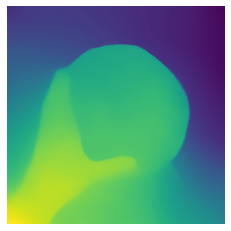

In [16]:
number=0

# for i in range(1):
for i in range(1000):
  
  setter_inew_model()

  
  path1_depth = '/content/test_vid/Frames'
  data_depth = os.listdir(path1_depth)
  ordedered_list = sorted(data_depth)
  ordedered_list = ordedered_list[1500:]

  # count = 0

  for e in ordedered_list[:1]:
    c = e
    input = '/content/test_vid/Frames/'+c
    print(input)
    img_ori = io.imread(input)
    # # print(input)(imgUMat),
    img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()
      
    output = prediction.cpu().numpy()
    plt.imshow(output)
    plt.axis('off')
    # number = 'f0' +'1'+ '.png'
    out = "/content/food%d.png" % number
    plt.savefig(out, bbox_inches='tight')
      

      
    
  move_image_new_model(number)
  remove(number)
  number += 1

  # for i in range(1):
  #  

  # for i in range(1):
    # 

   


In [17]:
#zero padding 
import shutil
import os

sourcedir = "/content/test_vid/new_model"; extensions = (".jpg", ".jpeg")
files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
maxlen = len(max([f[2] for f in files], key = len))

for item in files:
    zeros = maxlen-len(item[2])
    shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

##Converting it back to a video

In [18]:
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    #files.sort(key = lambda x: int(x[5:-4]))
    files = sorted(files)
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [19]:
pathIn= '/content/test_vid/new_model/'
pathOut = '/content/video1.mp4'
#enter the correct frame rates
fps = 30
convert_frames_to_video(pathIn, pathOut, fps)

/content/test_vid/new_model/00.jpg
/content/test_vid/new_model/01.jpg
/content/test_vid/new_model/02.jpg
/content/test_vid/new_model/03.jpg
/content/test_vid/new_model/04.jpg
/content/test_vid/new_model/05.jpg
/content/test_vid/new_model/06.jpg
/content/test_vid/new_model/07.jpg
/content/test_vid/new_model/08.jpg
/content/test_vid/new_model/09.jpg
/content/test_vid/new_model/10.jpg
/content/test_vid/new_model/11.jpg
/content/test_vid/new_model/12.jpg
/content/test_vid/new_model/13.jpg
/content/test_vid/new_model/14.jpg
/content/test_vid/new_model/15.jpg


### Download video

In [ ]:
assert False

In [ ]:
#Downloading video
from google.colab import files
files.download('/content/video1.mp4') 